#Boilerplate Code





## Imports

In [28]:
#Common imports
import numpy as np
from pprint import pprint

#to make this notebook's output stable across runs
np.random.seed(42)

#sklearn specific imports
#Dataset fetching
from sklearn.datasets import fetch_openml

#Feature scaling
from sklearn.preprocessing import MinMaxScaler

#pca
from sklearn.decomposition import PCA

#Pipeline utility
from sklearn.pipeline import make_pipeline

#Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

#model selection
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.model_selection import learning_curve

#Evaluation metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report,f1_score, make_scorer, precision_score

#To plot pretty figure
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

#global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

## Data Loading

In [29]:
X,y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [30]:
X=X.to_numpy()
y=y.to_numpy()
x_train, x_test, y_train, y_test =X[:60000],X[60000:],y[:60000],y[60000:]

# Binary Classification
## Change Labels to Binary




In [31]:
#initialize new variables names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train=='0')

y_train_0[indx_0]=1
indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

## Data Visualization in Lower Dimension

- Let us apply PCA on the datapoints and reduce the dimensions to 2D and then to 3D
- This will give us some rough idea about the points in $R^{784}$
- One interesting think to look at is the change in the magnitude of the data points before and after applying PCA
- we use the variables `pipe_pca_2d` for pre-processing the samples alone and `pipe_clf_pca_2d` for classification

In [32]:
pipe_pca_2d = make_pipeline(MinMaxScaler(),PCA(n_components=2))
x_train_pca_2d = pipe_pca_2d.fit_transform(x_train)

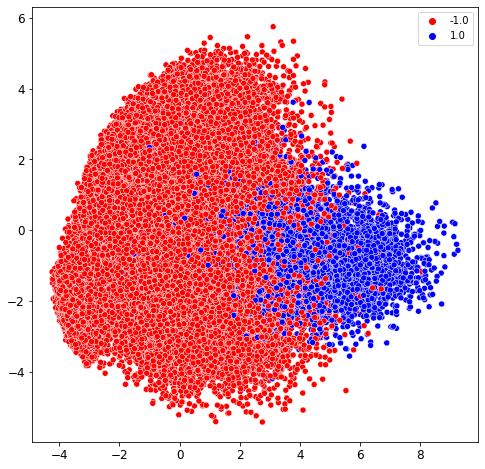

In [33]:
cmap=ListedColormap(['r','b'])
plt.figure(figsize=(8,8))
sns.scatterplot(x=x_train_pca_2d[:,0],y=x_train_pca_2d[:,1],hue=y_train_0,palette=cmap)
plt.show()

## Projection in 3D using PCA

In [34]:
pipe_pca_3d = make_pipeline(MinMaxScaler(),PCA(n_components=3))
x_train_pca_3d = pipe_pca_3d.fit_transform(x_train)

In [35]:
import plotly.express as px
fig = px.scatter_3d(x=x_train_pca_3d[:,0],
                 y=x_train_pca_3d[:,1],
                 z=x_train_pca_3d[:,2],
                 color=y_train_0,
                 color_discrete_map=cmap,
                 opacity=0.5)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

# KNN Classifier

## Algorithm

1. Set k to desired value, i.e how many neighbours should be allowed to participate in the prediction
2. Calculate the distance between new example and every other example from the data. Thus create a distance vector
3. Get indices of nearest k neighbors
4. Get the labels of the selected k entries
5. If it is a classification task, return the majority class by computing mode of the k labels

- To understand the working of sklearn built-in functions, we first create a KNN classifier model with k=3 and consider a smaller number of samples from training and testing set
- The `KNeighborClassifier` creates a classifier instance. There are many optional arguments such as `n_neighbors, metric, weights......` that can be set to suitable values while creating an instance.

In [36]:
#creating a new pipeline for classifier
pipe_clf_pca_2d = make_pipeline(pipe_pca_2d,KNeighborsClassifier(n_neighbors=3))

## Training with 10 samples

- Train the model with 10 samples from training set. Not building any parameterized model
- The test the model with 10 data points from test set


In [37]:
index_neg = np.argsort(y_train_0)[:5] #index of positive samples
index_pos = np.argsort(y_train_0)[-1:-6:-1] #index of negative samples

Sanity Check

In [38]:
#ensure first 10 samples are mix of both classes
print('Pos classes: ', y_train_0[index_pos])
print('Neg classes: ', y_train_0[index_neg])

Pos classes:  [1. 1. 1. 1. 1.]
Neg classes:  [-1. -1. -1. -1. -1.]


In [39]:
#create a small dataset
x=np.vstack((x_train[index_pos,:], x_train[index_neg,:]))
print(x.shape)
y=np.hstack((y_train_0[index_pos],y_train_0[index_neg]))
print(y.shape)

(10, 784)
(10,)


In [40]:
#Let us fit the model with new training set
pipe_clf_pca_2d.fit(x,y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [41]:
# for visualization
x_reduced = pipe_clf_pca_2d[0].transform(x)

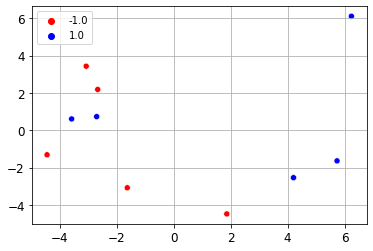

In [42]:
cmap=ListedColormap(['r','b'])
plt.figure(figsize=(6,4))
sns.scatterplot(x=x_reduced[:,0],y=x_reduced[:,1],marker='o',hue=y, palette=cmap)
plt.grid(True)
plt.show()

Test labels:  [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]


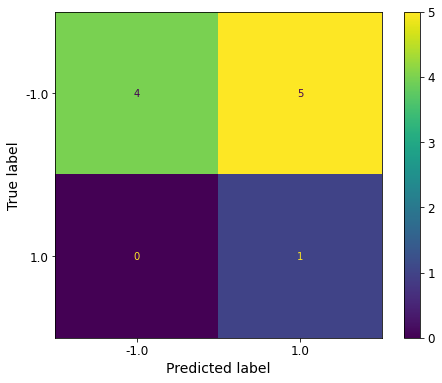

In [43]:
y_hat_0=pipe_clf_pca_2d.predict(x_test[:10,:])
ConfusionMatrixDisplay.from_predictions(y_test_0[:10],y_hat_0)
print('Test labels: ',y_test_0[:10])
plt.show()

- We can see that there are more FPs(since 9 out of 10 actual labels are negative)
- Let us display both the training points and testing points with their predictions
- We can visually validate the reason behind the performance

- It would be much better if we know the distance of 3 neigbors for each testing points
- Let us display the disance and connectivity of neighbors to the test datapoint(s) using the class NearestNEigbors
- In fact KNeighborsClassifier calls `NearestNeighbors` class internally to compute all these distance.

In [44]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=3)
neighbors.fit(pipe_pca_2d.transform(x))

NearestNeighbors(n_neighbors=3)

which are the first 3 closest neighbors to the first three in the test set? and how close are they ?

In [45]:
dist_neighbors, idx_neighbors = neighbors.kneighbors(pipe_pca_2d.transform(x_test[:10]),3,
                                                     return_distance=True)

In [46]:
import statistics
for i in range(3):
  print(f"Distance:{dist_neighbors[i]},\nIndex:{idx_neighbors[i]},\nLabels:{y[idx_neighbors[i].flatten()]},\nPredictions:{statistics.mode(y[idx_neighbors[i].flatten()])}")

Distance:[1.54510433 1.56004731 1.61914472],
Index:[1 4 6],
Labels:[ 1.  1. -1.],
Predictions:1.0
Distance:[0.95703587 3.33077652 3.39001596],
Index:[7 1 6],
Labels:[-1.  1. -1.],
Predictions:-1.0
Distance:[1.14297879 2.0379748  2.22709669],
Index:[6 4 1],
Labels:[-1.  1.  1.],
Predictions:1.0


## Training with 10000 samples
Now train the model with 10000 samples from training set

In [47]:
pipe_clf_pca_2d.fit(x_train[:10000],y_train_0[:10000])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

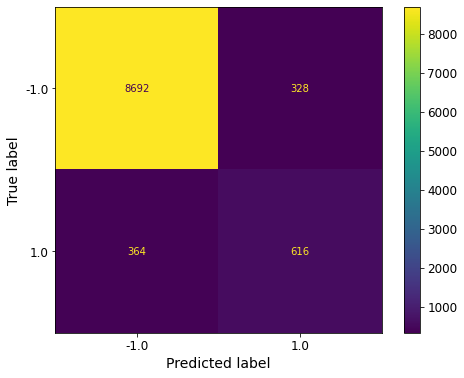

In [48]:
y_hat_0=pipe_clf_pca_2d.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_0)
plt.show()

In [49]:
print(classification_report(y_test_0,y_hat_0))

              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96      9020
         1.0       0.65      0.63      0.64       980

    accuracy                           0.93     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.93      0.93      0.93     10000



Very the `n_neighbors` from **k=1 to k=19** and study the performnace

In [50]:
precision=[]
for k in range(1,20,2):
  pipe_clf_pca_2d.__n_neigbors=k
  pipe_clf_pca_2d.fit(x_train[:10000],y_train_0[:10000])
  y_hat_0 = pipe_clf_pca_2d.predict(x_test)
  precision.append(precision_score(y_test_0,y_hat_0))

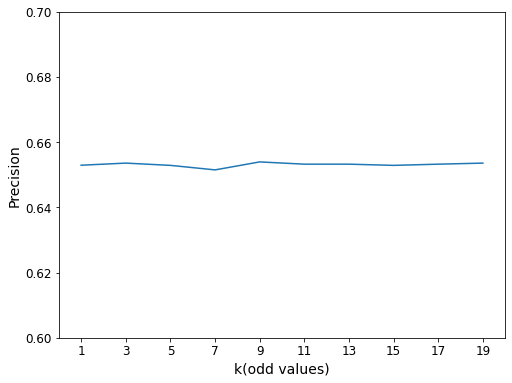

In [51]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1,20,2),precision)
plt.xlim((0,20))
plt.ylim((0.6,0.7))
plt.xlabel('k(odd values)')
plt.ylabel('Precision')
plt.xticks(ticks=np.arange(1,20,2), labels=np.arange(1,20,2))
plt.show()

## Going without PCA

In [52]:
pipe_knn = make_pipeline(MinMaxScaler(),KNeighborsClassifier(n_neighbors=1))

In [53]:
# grid_k = {'kneighborsclassifier__n_neighbors':[1,3,5,7,9,11]}
# cv = GridSearchCV(pipe_knn,param_grid=grid_k,scoring='precision',cv=5)
# cv.fit(x_train, y_train_0)
# print(cv)

In [54]:
# print(cv.cv_results_)

## Multi-Class Classification

In [55]:
print(pipe_knn)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])


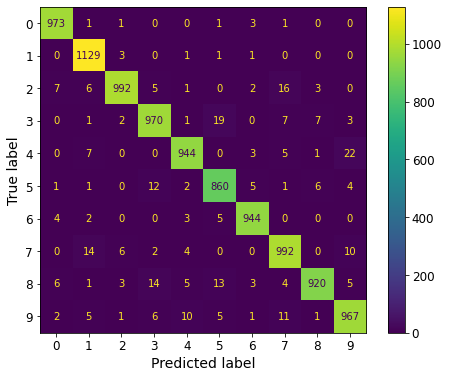

In [56]:
pipe_knn.fit(x_train,y_train)
y_hat = pipe_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test,y_hat)
plt.show()

In [57]:
pipe_knn.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [58]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# KNN with California Housing Dataset

In [59]:
import sklearn
assert sklearn.__version__ >="0.20"

In [66]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

## STEP:1=> Training data

### Loading the data

In [61]:
X,y = fetch_california_housing(return_X_y=True)

### Splitting data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=8)

### Preprocessing the dataset

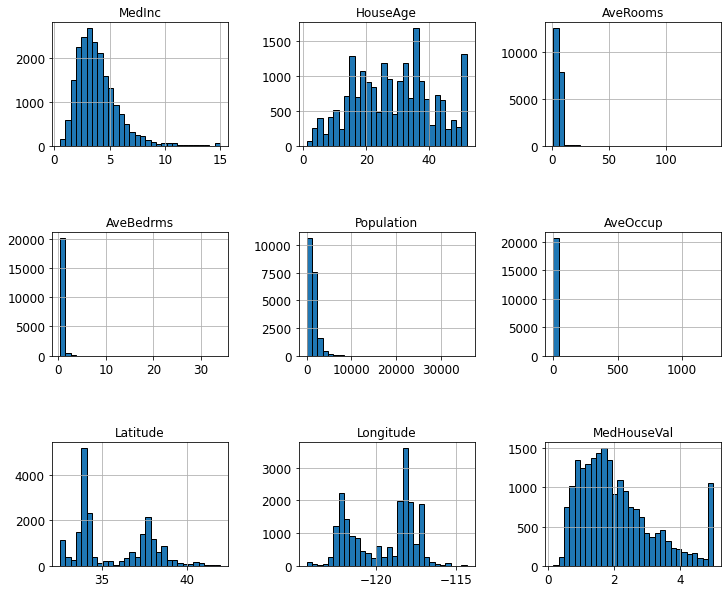

In [64]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.hist(figsize=(12,10),bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7,wspace=0.4)


Observe that the features are on different scales and we need to bring them on the same scale for k-NN
- k-NN usees eucidean distance computation to identify the nearest neighbors and it is crucial to have all the feautes on the same scale for that
- If all features are not on same scales, the feature with wider variance would dominate the distance calculation

## STEP-2: Model Building

In [68]:
pipe= Pipeline([('scaler',MinMaxScaler()),('knn',KNeighborsRegressor(n_neighbors=2))])
pipe.fit(X_train,y_train)
y_pred= pipe.predict(X_test)
error= mean_squared_error(y_test, y_pred, squared=False)
print(error)

0.6767822465759739


## STEP:3 Model Selection and Evaluation

Tunig of hyper parameter using
- Manula hyper_parameter tuning
- Using `GridSearchCV` or `RandomizedSearchCV`

### Manual HPT with cross validation

In [69]:
rmse_val =[]
for K in range(1,31):
  pipe= Pipeline([('scaler',MinMaxScaler()),('knn',KNeighborsRegressor(n_neighbors=K))])

  pipe.fit(X_train,y_train)

  pred= pipe.predict(X_test)

  error = mean_squared_error(y_test,pred,squared=False)
  rmse_val.append(error)

In [72]:
len(rmse_val)

30

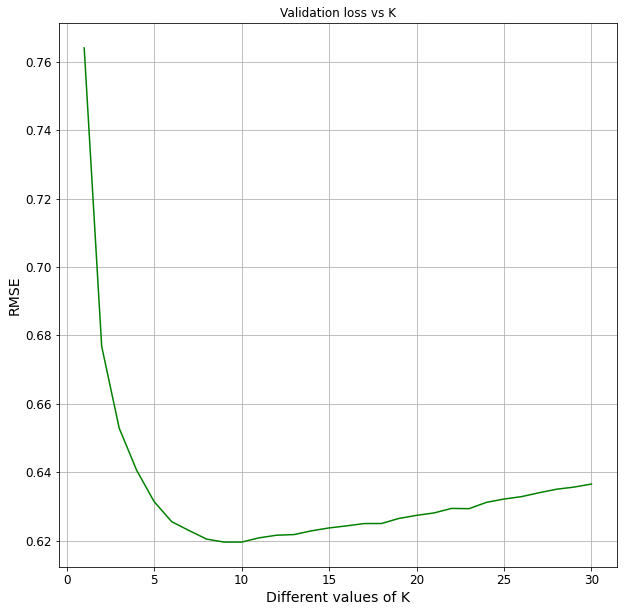

In [73]:
plt.figure(figsize=(10,10))

plt.plot(range(1,len(rmse_val)+1),rmse_val,color='green')
plt.xlabel('Different values of K')
plt.ylabel('RMSE')
plt.grid(True)

plt.title('Validation loss vs K')
plt.show()

### HPT with `GridSearchCV`

In [74]:
param_grid = {'knn__n_neighbors':list(range(1,31))}
print(param_grid)
pipe= Pipeline([('scaler',MinMaxScaler()),('knn',KNeighborsRegressor())])
gs=GridSearchCV(estimator=pipe,
                param_grid=param_grid,
                cv=10,n_jobs=-1,
                return_train_score=True)
gs.fit(X_train, y_train)


{'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]},
             return_train_score=True)

In [75]:
reg_knn=gs.best_estimator_
print(reg_knn)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=6))])


In [77]:
pred=gs.best_estimator_.predict(X_test)
error = mean_squared_error(y_test,pred,squared=False)
print('RMSE value for k is: ',error)

RMSE value for k is:  0.6255268557053962


### Polynomial Features

In [80]:
params = {'poly__degree':list(range(1,4)),
          'knn__n_neighbors': list(range(6,12))}
print(params)
pipe= Pipeline([('poly',PolynomialFeatures()),('scaler',MinMaxScaler()),('knn',KNeighborsRegressor())])
gs= GridSearchCV(estimator=pipe,
                 param_grid=params,
                 cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
reg_knn = gs.best_estimator_
print(reg_knn)

{'poly__degree': [1, 2, 3], 'knn__n_neighbors': [6, 7, 8, 9, 10, 11]}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('scaler', MinMaxScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=6))])


In [81]:
pred=gs.best_estimator_.predict(X_test)
error = mean_squared_error(y_test,pred,squared=False)
print('RMSE value for k is: ',error)

RMSE value for k is:  0.6255268557053962
